<a href="https://colab.research.google.com/github/risper25/Personalised-Recommendation-Model-for-Online-Comedy-TV./blob/main/matrix_factorization_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats

# Read file:

In [2]:
#!unzip /content/train.zip
train=pd.read_csv("/content/train.csv")
train.head()

,Viewers_ID,Joke_identifier,Response_ID,Rating
0,A1,Klint De Drunk Enugu 1,A1_Klint De Drunk Enugu 1,0.11
1,A1,Klint De Drunk Enugu 2,A1_Klint De Drunk Enugu 2,-4.64
2,A1,Klint De Drunk PH 1,A1_Klint De Drunk PH 1,-3.39
3,A1,Klint De Drunk PH 2,A1_Klint De Drunk PH 2,0.44
4,A1,Klint De Drunk Lagos 1,A1_Klint De Drunk Lagos 1,-4.83


In [3]:
#shape
print(train.shape)

(612702, 4)


#**EDA**(Exploratory Data Analysis)


In [4]:
#split the joke identifier into three parts: the comedy name,event location and part.
train['Joke_split']=train['Joke_identifier'].apply(lambda x:x.rsplit(' ', 2))
train['Joke']=train['Joke_split'].apply(lambda x:x[0])
train['location']=train['Joke_split'].apply(lambda x:x[1])
train['joke_part']=train['Joke_split'].apply(lambda x:x[2])
train.head()

,Viewers_ID,Joke_identifier,Response_ID,Rating,Joke_split,Joke,location,joke_part
0,A1,Klint De Drunk Enugu 1,A1_Klint De Drunk Enugu 1,0.11,"[Klint De Drunk, Enugu, 1]",Klint De Drunk,Enugu,1
1,A1,Klint De Drunk Enugu 2,A1_Klint De Drunk Enugu 2,-4.64,"[Klint De Drunk, Enugu, 2]",Klint De Drunk,Enugu,2
2,A1,Klint De Drunk PH 1,A1_Klint De Drunk PH 1,-3.39,"[Klint De Drunk, PH, 1]",Klint De Drunk,PH,1
3,A1,Klint De Drunk PH 2,A1_Klint De Drunk PH 2,0.44,"[Klint De Drunk, PH, 2]",Klint De Drunk,PH,2
4,A1,Klint De Drunk Lagos 1,A1_Klint De Drunk Lagos 1,-4.83,"[Klint De Drunk, Lagos, 1]",Klint De Drunk,Lagos,1


In [5]:
#unique values for categorical variables
print(train.Joke.unique())
print("="*80)
print(train.location.unique())
print("="*80)
print(train.joke_part.unique())

['Klint De Drunk' 'Klint De Drunk Warri' 'AliBaba' 'AliBaba Aso'
 'BasketMouth' 'AY' 'Bovi' 'Akpororo' 'I Go Dye' 'Helen Paul' 'Seyi Law'
 'Gordons' 'Saka' 'Okey Bakassi' 'Funny Bone']
['Enugu' 'PH' 'Lagos' '1' 'Rock' 'Abuja' 'Warri' 'Owerri' 'Benin' 'Uyo'
 'Ibadan']
['1' '2' '3' '' '4' '5']


In [6]:
#correct Kilit de Drunk Warri
train.loc[train['Joke'] == 'Klint De Drunk Warri', ['Joke','location','joke_part']] = ['Klint De Drunk', 'Warri','1']
train.Joke.unique()

array(['Klint De Drunk', 'AliBaba', 'AliBaba Aso', 'BasketMouth', 'AY',
       'Bovi', 'Akpororo', 'I Go Dye', 'Helen Paul', 'Seyi Law',
       'Gordons', 'Saka', 'Okey Bakassi', 'Funny Bone'], dtype=object)

## univariate distribution for comedy,event location and part.

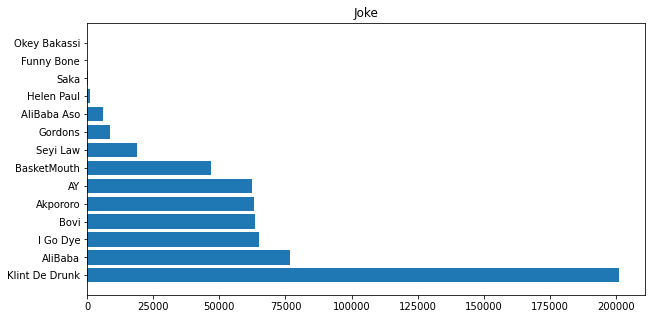

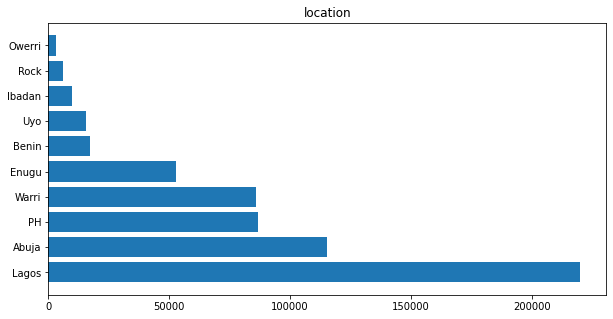

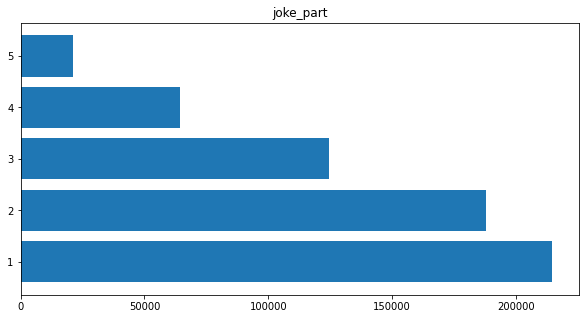

In [7]:
cols=['Joke','location','joke_part']

for c in cols:
    print(" ")
    counts =train[c].value_counts()
    plt.figure(figsize=(10, 5))
    plt.barh(counts.index, counts.values)
    plt.title(c)
    plt.show()

Number of locations for each comedy event

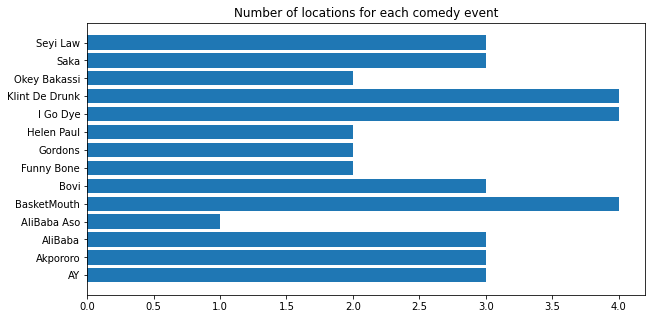

In [8]:
counts = train.groupby('Joke')['location'].nunique().reset_index(name='Count')
plt.figure(figsize=(10, 5))
plt.barh(counts.Joke,counts.Count)
plt.title("Number of locations for each comedy event")

plt.show()

Positive and Negative Ratings proportions for each joke.

Text(0.5, 1.0, 'Positive and Negative Ratings proportions for each joke')

<Figure size 720x360 with 0 Axes>

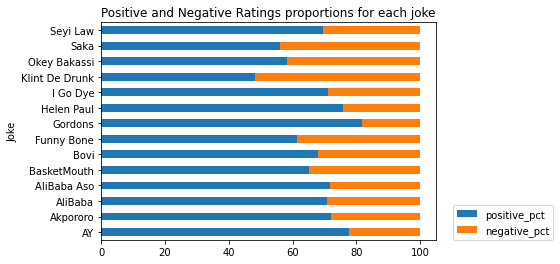

In [9]:
import numpy as np
#positive and negative ratings
train['sentiment']=train['Rating'].apply(lambda x: 'positive' if x > 0 else 'negative')
sentiment_counts= train.groupby(['Joke', 'sentiment']).size().reset_index(name='count')
# Calculate the percentage of each sentiment for each value of var1
sentiment_counts = sentiment_counts.pivot(index='Joke', columns='sentiment', values='count').reset_index()
sentiment_counts['positive_pct'] = sentiment_counts['positive'] / (sentiment_counts['positive'] + sentiment_counts['negative'])*100
sentiment_counts['negative_pct'] = sentiment_counts['negative'] / (sentiment_counts['positive'] + sentiment_counts['negative'])*100
sentiment_counts.drop(['negative','positive'], inplace=True, axis=1)
plt.figure(figsize=(10, 5))
sentiment_counts.plot(x='Joke',kind='barh',stacked=True)
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0.)
plt.title("Positive and Negative Ratings proportions for each joke")

Number of Comedy Events Watched by Users

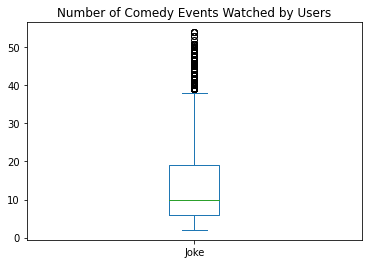

In [10]:
#boxplot
counts=train.groupby('Viewers_ID')['Joke'].count()
counts.plot.box(title="Number of Comedy Events Watched by Users")

In [11]:
train['Joke'] = train['Joke'] + ' ' + train['location'] 


## Encoding.

In [12]:
def index_ID(column):
    list_n=pd.unique(train[column])
    dict_n={n:i for i,n in enumerate(list_n)}
    return dict_n
def list_index(column,dict_x):
    l_d=[dict_x[d] for d in train[column]]
    return l_d

def get_name(mydict, search_number):
    res = dict((v,k) for k,v in mydict.items())
    return res[search_number]

In [13]:
#users
dict_u=index_ID("Viewers_ID")
u=list_index("Viewers_ID",dict_u)
n_users=len(dict_u)
train['Viewers_ID']=u
#comedy event
dict_v=index_ID("Joke")
v=list_index("Joke",dict_v)
n_movies=len(dict_v)
train['Joke']=v
train.head()

,Viewers_ID,Joke_identifier,Response_ID,Rating,Joke_split,Joke,location,joke_part,sentiment
0,0,Klint De Drunk Enugu 1,A1_Klint De Drunk Enugu 1,0.11,"[Klint De Drunk, Enugu, 1]",0,Enugu,1,positive
1,0,Klint De Drunk Enugu 2,A1_Klint De Drunk Enugu 2,-4.64,"[Klint De Drunk, Enugu, 2]",0,Enugu,2,negative
2,0,Klint De Drunk PH 1,A1_Klint De Drunk PH 1,-3.39,"[Klint De Drunk, PH, 1]",1,PH,1,negative
3,0,Klint De Drunk PH 2,A1_Klint De Drunk PH 2,0.44,"[Klint De Drunk, PH, 2]",1,PH,2,positive
4,0,Klint De Drunk Lagos 1,A1_Klint De Drunk Lagos 1,-4.83,"[Klint De Drunk, Lagos, 1]",2,Lagos,1,negative


In [14]:
n_users=train.Viewers_ID.nunique()
print(n_users)
n_joke=train.Joke.nunique()
print(n_joke)

40863
39


## Split data

In [15]:
#split dataset into training and validation set
y=train["Rating"]
X=train.drop("Rating",axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,train_size=0.7, random_state=42,stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

##Build model 


In [16]:
#MF
class MF(torch.nn.Module):
    def __init__(self,n_users,n_movies,n_factors):
        super().__init__()
        #user embedings
        self.users_emb=torch.nn.Embedding(n_users,n_factors,sparse=True)
        #movies embeding
        self.movies_emb=torch.nn.Embedding(n_movies,n_factors,sparse=True)

        self.user_biases = torch.nn.Embedding(n_users, 1,sparse=True)
        self.item_biases = torch.nn.Embedding(n_movies, 1,sparse=True)

        self.users_emb.weight.data.uniform_(0,0.05)
        self.movies_emb.weight.data.uniform_(0,0.05)
    
    def forward(self,u,m):
        #return (self.users_emb(u)*self.movies_emb(m)).sum(1)

        #return a dot matrix multiplication of u . M element wise
        pred = self.user_biases(u) + self.item_biases(m)
        pred += (
           (self.users_emb(u)*self.movies_emb(m)).sum(1,keepdim=True)
        )
        return pred.squeeze()
        




## Train

In [17]:
def train(model,epochs,optimizer,loss_fn):
    train_loss=[]
    valid_loss=[]
    for e in range(epochs):
        model.train()
        u=torch.LongTensor(X_train.Viewers_ID.values)
        v=torch.LongTensor(X_train.Joke.values)
        r=torch.FloatTensor(y_train.values)
        #forward
        out=model.forward(u,v)
        #rmse

        loss=torch.sqrt(loss_fn(out,r))
        model.zero_grad()
        loss.backward()
        optimizer.step()
        #validation
        loss_v=validate(model)
        #scheduler.step()
        train_loss.append(loss.item())
        valid_loss.append(loss_v.item())
        print('epoch',e+1,end =" ")
        print("loss:",loss.item(),end =" "),
        print("loss v: ",loss_v.item())
    plot_losses(train_loss,valid_loss)



In [18]:
#validate
def validate(model):
    model.eval()
    u=torch.LongTensor(X_val.Viewers_ID.values)
    v=torch.LongTensor(X_val.Joke.values)
    r=torch.FloatTensor(y_val.values)
    out=model.forward(u,v)
    loss=torch.sqrt(loss_fn(out,r))
    return loss

In [19]:
#test
def test():
    #load model
    model.eval()
    u=torch.LongTensor(X_test.Viewers_ID.values)
    v=torch.LongTensor(X_test.Joke.values)
    r=torch.FloatTensor(y_test.values)
    out=model.forward(u,v)
    loss=torch.sqrt(loss_fn(out,r))
    return loss.item()


In [20]:

from matplotlib.pylab import plt
from numpy import arange
def plot_losses(train_values,val_values):
    # Generate a sequence of integers to represent the epoch numbers
    epochs = range(1, len(train_values)+1)
    # Plot and label the training and validation loss values
    plt.plot(epochs, train_values, label='Training Loss')
    plt.plot(epochs, val_values, label='Validation Loss')
    # Add in a title and axes labels
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # Set the tick locations
    plt.xticks(arange(0, len(epochs), len(epochs)/4))
    # Display the plot
    plt.legend(loc='best')
    plt.show()





epoch 1 loss: 3.218708038330078 loss v:  3.2052948474884033
epoch 2 loss: 3.189531087875366 loss v:  3.1729257106781006
epoch 3 loss: 3.154219150543213 loss v:  3.134939670562744
epoch 4 loss: 3.112328052520752 loss v:  3.091627597808838
epoch 5 loss: 3.063995122909546 loss v:  3.0436248779296875
epoch 6 loss: 3.00968337059021 loss v:  2.991875410079956
epoch 7 loss: 2.950152635574341 loss v:  2.9376981258392334
epoch 8 loss: 2.886537790298462 loss v:  2.8828284740448
epoch 9 loss: 2.820404529571533 loss v:  2.8293702602386475
epoch 10 loss: 2.7537288665771484 loss v:  2.7796452045440674
epoch 11 loss: 2.688795566558838 loss v:  2.735922336578369
epoch 12 loss: 2.6279802322387695 loss v:  2.6999716758728027
epoch 13 loss: 2.5733580589294434 loss v:  2.6725008487701416
epoch 14 loss: 2.5261757373809814 loss v:  2.652804374694824
epoch 15 loss: 2.486461639404297 loss v:  2.6389644145965576
epoch 16 loss: 2.4530985355377197 loss v:  2.6285183429718018
epoch 17 loss: 2.424328565597534 loss

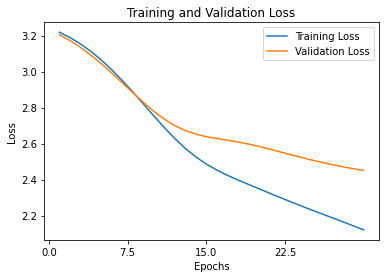

In [21]:
n_emb=100
model=MF(n_users,n_joke,n_emb)
loss_fn=torch.nn.MSELoss()
optimizer=torch.optim.SparseAdam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=10)
train(model,30,optimizer,loss_fn)


## Test

In [22]:
print('test loss: ',test())

test loss:  2.4269800186157227
